In [19]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [20]:
# خواندن داده‌ها
movies_df = pd.read_csv(r'F:\JUPYTER\notbook\trainingn\csv\movies.csv')
ratings_df = pd.read_csv(r'F:\JUPYTER\notbook\trainingn\csv\ratings.csv')

In [21]:
ratings_df = ratings_df.sort_values('timestamp')

# انتخاب درصدی از داده‌ها برای کاهش حجم محاسبات
n_users = len(ratings_df['userId'].unique())
n_movies = len(ratings_df['movieId'].unique())
print(f"تعداد کل کاربران: {n_users}")
print(f"تعداد کل فیلم‌ها: {n_movies}")


تعداد کل کاربران: 610
تعداد کل فیلم‌ها: 9724


In [22]:
# انتخاب کاربران و فیلم‌های پرتکرار
min_movie_ratings = 50  # حداقل تعداد امتیاز برای هر فیلم
min_user_ratings = 50   # حداقل تعداد امتیاز برای هر کاربر

In [23]:
# فیلتر کردن فیلم‌ها
movie_counts = ratings_df['movieId'].value_counts()
popular_movies = movie_counts[movie_counts >= min_movie_ratings].index
filtered_ratings = ratings_df[ratings_df['movieId'].isin(popular_movies)]


In [24]:
# فیلتر کردن کاربران
user_counts = filtered_ratings['userId'].value_counts()
active_users = user_counts[user_counts >= min_user_ratings].index
filtered_ratings = filtered_ratings[filtered_ratings['userId'].isin(active_users)]


In [25]:
print(f"تعداد کاربران پس از فیلتر: {len(filtered_ratings['userId'].unique())}")
print(f"تعداد فیلم‌ها پس از فیلتر: {len(filtered_ratings['movieId'].unique())}")


تعداد کاربران پس از فیلتر: 268
تعداد فیلم‌ها پس از فیلتر: 450


In [26]:
# تقسیم داده‌ها به train و test
train_data, test_data = train_test_split(filtered_ratings, test_size=0.2, random_state=42)


In [27]:
# مثال استفاده از سیستم توصیه‌گر
test_user_id = 1
recommendations = get_user_recommendations(test_user_id)
print(f"\nپیشنهادات برای کاربر {test_user_id}:")
print(recommendations)



پیشنهادات برای کاربر 1:
   movieId  predicted_rating  \
0      318          2.622414   
1      589          2.061920   
2      858          1.836914   
3     2762          1.643315   
4     4993          1.605043   

                                               title                genres  
0                   Shawshank Redemption, The (1994)           Crime|Drama  
1                  Terminator 2: Judgment Day (1991)         Action|Sci-Fi  
2                              Godfather, The (1972)           Crime|Drama  
3                            Sixth Sense, The (1999)  Drama|Horror|Mystery  
4  Lord of the Rings: The Fellowship of the Ring,...     Adventure|Fantasy  


In [28]:
# تحلیل و ارزیابی سیستم
# میانگین امتیازها برای هر فیلم
avg_ratings = ratings_df.groupby('movieId')['rating'].mean()

In [29]:
# ساخت ماتریس‌های train و test
train_matrix = train_data.pivot(
    index='userId',
    columns='movieId',
    values='rating'
).fillna(0)


In [30]:
test_matrix = test_data.pivot(
    index='userId',
    columns='movieId',
    values='rating'
).fillna(0)

In [31]:
# اطمینان از یکسان بودن ستون‌ها
common_columns = set(train_matrix.columns) & set(test_matrix.columns)
train_matrix = train_matrix[list(common_columns)]
test_matrix = test_matrix[list(common_columns)]


In [32]:
# محاسبه شباهت کاربران با داده‌های آموزش
train_user_similarity = cosine_similarity(train_matrix)

def predict_ratings(user_id, user_similarities, train_data):
    """
    پیش‌بینی امتیازها برای یک کاربر با استفاده از میانگین وزن‌دار امتیازهای کاربران مشابه
    """
    # انتخاب بهترین کاربران مشابه (مثلاً 10 کاربر)
    n_similar = 10
    similar_user_indices = np.argsort(user_similarities)[-n_similar:]
    similar_user_sims = user_similarities[similar_user_indices]
    
    # امتیازهای کاربران مشابه
    similar_user_ratings = train_data.iloc[similar_user_indices]
    
    # میانگین وزن‌دار
    weighted_sum = np.sum(similar_user_ratings * similar_user_sims[:, np.newaxis], axis=0)
    sim_sum = np.sum(similar_user_sims)
    
    if sim_sum != 0:
        predicted = weighted_sum / sim_sum
    else:
        predicted = np.zeros(train_data.shape[1])
        
    return predicted


In [33]:
# پیش‌بینی برای داده‌های تست
predicted_ratings = np.zeros_like(test_matrix.values)
for i, user_id in enumerate(test_matrix.index):
    if user_id in train_matrix.index:
        user_idx = list(train_matrix.index).index(user_id)
        user_similarities = train_user_similarity[user_idx]
        predicted_ratings[i] = predict_ratings(user_id, user_similarities, train_matrix)


In [34]:
# محاسبه RMSE
def calculate_rmse(true_ratings, predicted_ratings):
    """محاسبه RMSE بین امتیازهای واقعی و پیش‌بینی شده"""
    mask = true_ratings != 0
    return np.sqrt(mean_squared_error(true_ratings[mask], predicted_ratings[mask]))

rmse = calculate_rmse(test_matrix.values, predicted_ratings)
print(f"\nRMSE on test set: {rmse:.4f}")



RMSE on test set: 2.2591


In [37]:
# تابع توصیه‌گر برای کاربر
def get_user_recommendations(user_id, n_recommendations=5):
    """
    برای یک کاربر خاص، فیلم‌های پیشنهادی را برمی‌گرداند
    """
    if user_id not in train_matrix.index:
        return "کاربر در مجموعه داده آموزش یافت نشد."
    
    user_idx = list(train_matrix.index).index(user_id)
    user_similarities = train_user_similarity[user_idx]
    predicted = predict_ratings(user_id, user_similarities, train_matrix)
    
    # فیلم‌هایی که کاربر هنوز ندیده است
    user_ratings = train_matrix.loc[user_id]
    unwatched_mask = user_ratings == 0
    
    # امتیازهای پیش‌بینی شده برای فیلم‌های ندیده
    predicted_unwatched = predicted[unwatched_mask]
    movie_ids = train_matrix.columns[unwatched_mask]
    
    # مرتب‌سازی و انتخاب بهترین پیشنهادات
    recommendations = pd.DataFrame({
        'movieId': movie_ids,
        'predicted_rating': predicted_unwatched
    })
    recommendations = recommendations.sort_values('predicted_rating', ascending=False)
    recommendations = recommendations.head(n_recommendations)
    
    # اضافه کردن اطلاعات فیلم
    recommendations = recommendations.merge(movies_df[['movieId', 'title', 'genres']], on='movieId')
    
    return recommendations

# نمونه استفاده
test_user_id = test_matrix.index[0]
# Reset index to make 'movieId' a normal column
recommendations = recommendations.reset_index()

# Now perform the merge
recommendations = recommendations.merge(movies_df[['movieId', 'title', 'genres']], on='movieId')
print(f"\nپیشنهادات برای کاربر {test_user_id}:")
print(recommendations)


KeyError: 'movieId'

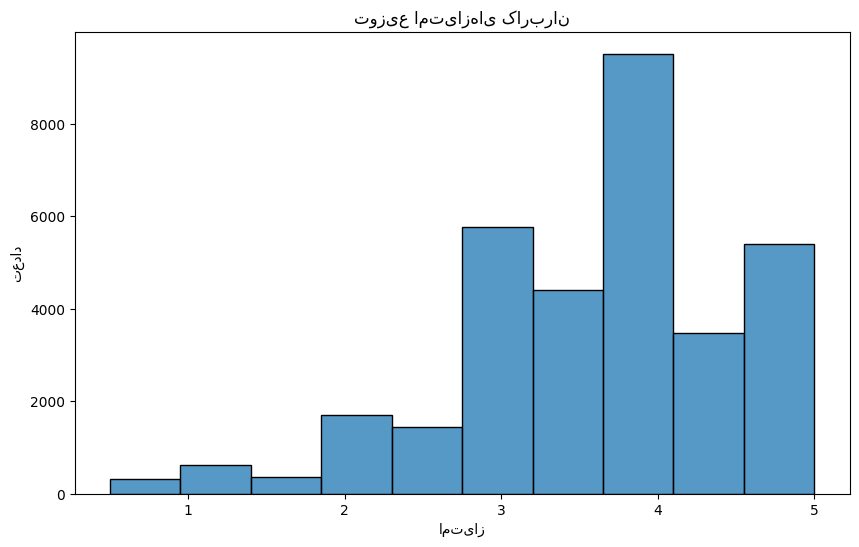

In [38]:
# نمودار توزیع امتیازها
plt.figure(figsize=(10, 6))
sns.histplot(filtered_ratings['rating'], bins=10)
plt.title('توزیع امتیازهای کاربران')
plt.xlabel('امتیاز')
plt.ylabel('تعداد')
plt.show()
